In [1]:
import numpy as np
import pandas as pd

file_path = 'res.csv'
data = pd.read_csv(file_path)

# Extend the dataset to repeat each image 3 times
data_extended = pd.concat([data] * 4, ignore_index=True)

# Set total queries, models, and servers
T = 200000  # Total number of queries after extending the dataset
K = 6       # Number of models
# S will be defined later, for now it will be a parameter

# Extract model-specific data: accuracy and inference time for each image
models = ['resnet', 'vgg', 'inception', 'efficientnet', 'alexnet', 'mobilenet']
model_data = {model: data_extended[data_extended['model'] == model] for model in models}

# Identify the best model (EfficientNet)
best_model = 'efficientnet'
best_model_accuracy = data_extended[data_extended['model'] == best_model]['accuracy'].mean()

class Arm:
    def __init__(self, model_name, data):
        self.model_name = model_name
        self.data = data

        self._mean_hat = 0.0  # Estimated mean accuracy
        self._ucb = float("inf")       # Upper confidence bound
        self._total_pulls = 0          # Number of times this model has been selected

    def _update_arm(self, result):
        self._total_pulls += 1
        self._mean_hat = self._mean_hat + (result - self._mean_hat) / self._total_pulls
        self._ucb = self._mean_hat + np.sqrt(np.log(2 * T) / self._total_pulls)

    def update_arm(self, query_id):
        # Get accuracy from the dataset for the given query
        result = self.data['accuracy'].iloc[query_id % len(self.data)]  # Loop over data if needed
        self._update_arm(result)
        return result

    def get_inference_time(self, query_id):
        # Get the inference time for the corresponding query
        return self.data['inference_time'].iloc[query_id % len(self.data)]

# Select the arm (model) with the highest UCB
def get_arm_to_pull(arms):
    best_arm = max(arms, key=lambda arm: arm._ucb)
    return best_arm

# Trial class to represent the processing of a query by a server
class Trial:
    def __init__(self, start_time, arm, query_id):
        self._start_time = start_time
        self._end_time = self._start_time + arm.get_inference_time(query_id)  # Use inference time from data
        self._arm = arm
        self._query_id = query_id

    def run_trial(self, current_time):
        if current_time < self._end_time:
            return False, None
        # Query is done, update the arm with the result from this query
        reward = self._arm.update_arm(self._query_id)
        return True, reward

# The trivial BMAB algorithm, processing in batches of size S
def run_trivial_offline_bmab(S):
    # Initialize UCB values and counters for each model
    UCB = {model: np.inf for model in models}
    T_i = {model: 0 for model in models}  # Number of pulls for each model
    mean_estimator = {model: 0 for model in models}  # Mean accuracy estimates for each model
    
    # Initialize total regret and total inference time
    total_regret = 0
    total_inference_time = 0
    
    M = T // S  # Number of batches

    for m in range(M):
        # Select model based on UCB for all S servers
        selected_model = max(UCB, key=UCB.get)

        # Extract images for this batch, from m*S to (m+1)*S - 1
        batch_start = m * S
        batch_end = batch_start + S
        current_model_data = model_data[selected_model]
        batch_data = current_model_data.iloc[batch_start:batch_end]
        #print('m=',m,batch_data)
        
        # Update the number of pulls for the selected model
        T_i[selected_model] += S
        
        # Extract accuracies and inference times for the current batch
        batch_accuracies = batch_data['accuracy'].values
        batch_inference_times = batch_data['inference_time'].values
        
        # Calculate the mean accuracy for the batch
        batch_mean_accuracy = np.mean(batch_accuracies)
        
        # Update mean estimator for the selected model
        prev_mean = mean_estimator[selected_model]
        new_mean = (prev_mean * (T_i[selected_model] - S) + batch_mean_accuracy * S) / T_i[selected_model]
        mean_estimator[selected_model] = new_mean
        
        # Update UCB for the selected model
        UCB[selected_model] = new_mean + np.sqrt(np.log(2 * T) / T_i[selected_model])
        
        # Calculate regret for this batch
        batch_regret = (best_model_accuracy - batch_mean_accuracy) * S
        total_regret += batch_regret
        
        # Add the maximum inference time from this batch to the total running time
        total_inference_time += max(batch_inference_times)
        
        # Update UCB for models that were not selected (they retain their previous UCB)
        for model in models:
            if model != selected_model and T_i[model] > 0:
                UCB[model] = mean_estimator[model] + np.sqrt(np.log(2 * T) / T_i[model])
    
    # Return total regret and total running time
    return total_regret, total_inference_time



# The BMAB algorithm based on the updated system
def run_offline_bmab(S, coef):
    # Initialize mean estimators and counters for each model
    T_i = {model: 0 for model in models}  # Number of pulls for each model
    sum_estimator = {model: 0 for model in models}  # Sum accuracy estimates for each model
    
    # Initialize total regret and total inference time
    total_regret = 0
    total_inference_time = 0
    
    M = T // S  # Number of batches

    # Active set of models A^m, starts with all models
    active_models = models.copy()

    for m in range(M):
        # Uniformly select an arm (model) from the active set for each server
        # selected_models = np.random.choice(active_models, size=S)
        
        L = len(active_models)

        # Collect rewards for each selected model
        batch_accuracies = []
        batch_inference_times = []
        
        for i in range(S):
            selected_model = active_models[i % L]
            current_model_data = model_data[selected_model].iloc[m*S+i: m*S+i+1]

            T_i[selected_model] += 1
            
            # Record accuracy and inference time
            current_accuracy = current_model_data['accuracy'].values[0]
            batch_accuracies.append(current_accuracy)
            batch_inference_times.append(current_model_data['inference_time'].values[0])
            
            # Update sum estimator for the selected model
            sum_estimator[selected_model] += current_accuracy
        
        # Update total inference time
        total_inference_time += max(batch_inference_times)

        # Calculate regret for this batch
        batch_mean_accuracy = np.mean(batch_accuracies)
        batch_regret = (best_model_accuracy - batch_mean_accuracy) * S
        total_regret += batch_regret
        
        # Update the active set for the next batch
        if min(T_i.values())>0:
            max_lower_confidence_bound = max(sum_estimator[model]/T_i[model] - coef * np.sqrt(np.log(2 * T * K) / max(T_i[model], 1)) for model in active_models)
            active_models = [
                model for model in active_models
                if sum_estimator[model]/T_i[model] > max_lower_confidence_bound
            ]
        #print(active_models)
    
    # Return total regret and total running time
    return total_regret, total_inference_time

def run_online_bmab(S):
    # Initialize the arms (models) using the loaded data
    arms = [Arm(model_name, model_data[model_name]) for model_name in models]

    current_time = 0
    total_reward = 0
    query_processed = 0
    query_id = 0

    # Initialize servers (each server can process one trial at a time)
    trials = [None] * S

    # Main loop for processing queries
    while query_processed < T:
        
        # Assign new queries to servers that have completed their current trial
        for i in range(S):
            if trials[i] is None:  # Server is available for a new query
                selected_arm = get_arm_to_pull(arms)  # Select the model (arm) with the highest UCB
                trials[i] = Trial(current_time, selected_arm, query_id)  # Assign the next query
                query_id += 1

            # Run the trial and check if it is completed
            done, reward = trials[i].run_trial(current_time)
            if done:
                total_reward += reward  # Accumulate the total reward (accuracy)
                query_processed += 1  # Increment the query processed count
                trials[i] = None  # Free up the server for the next query

        # Advance current_time to the earliest end time among the servers
        current_time = min(trial._end_time for trial in trials if trial is not None)

    # Calculate total regret (difference between oracle and achieved reward)
    oracle_reward = max([arm.data['accuracy'].mean() for arm in arms]) * T
    total_regret = oracle_reward - total_reward

    return total_regret, current_time

<ipython-input-1-acb6db691657>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


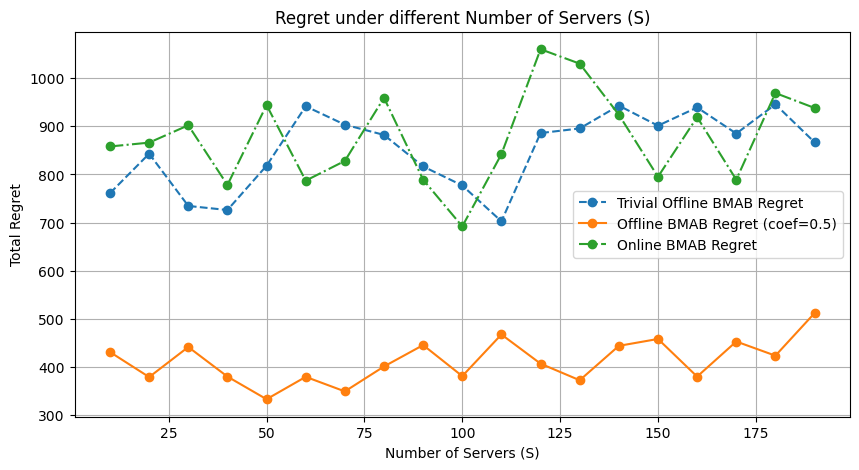

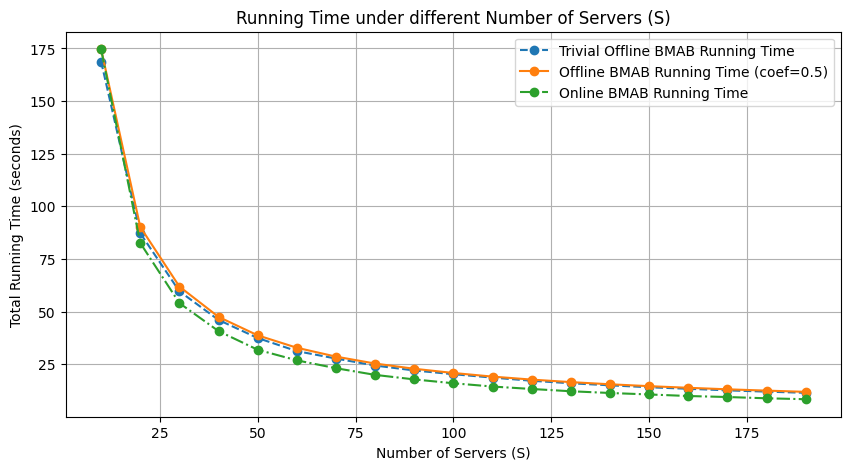

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define different batch sizes (S) to test
S_values = np.arange(10, 200, 10)

# Initialize lists to store results for each S
trivial_regret_values = []
trivial_running_time_values = []
offline_bmab_regret_values = []
offline_bmab_running_time_values = []
online_bmab_regret_values = []
online_bmab_running_time_values = []

# Coefficient for Offline BMAB
coef = 0.5

# Run the BMAB and Trivial BMAB algorithms for each S and store the results
for S in S_values:
    # Run trivial offline BMAB as a benchmark
    trivial_regret, trivial_total_running_time = run_trivial_offline_bmab(S)
    trivial_regret_values.append(trivial_regret)
    trivial_running_time_values.append(trivial_total_running_time)

    # Run offline BMAB with coefficient
    offline_bmab_regret, offline_bmab_total_running_time = run_offline_bmab(S, coef)
    offline_bmab_regret_values.append(offline_bmab_regret)
    offline_bmab_running_time_values.append(offline_bmab_total_running_time)

    # Run online BMAB
    online_bmab_regret, online_bmab_total_running_time = run_online_bmab(S)
    online_bmab_regret_values.append(online_bmab_regret)
    online_bmab_running_time_values.append(online_bmab_total_running_time)

# Plot Regret over S for Trivial Offline BMAB, Offline BMAB, and Online BMAB
plt.figure(figsize=(10, 5))
plt.plot(S_values, trivial_regret_values, marker='o', label='Trivial Offline BMAB Regret', linestyle='--')
plt.plot(S_values, offline_bmab_regret_values, marker='o', label=f'Offline BMAB Regret (coef={coef})', linestyle='-')
plt.plot(S_values, online_bmab_regret_values, marker='o', label='Online BMAB Regret', linestyle='-.')
plt.xlabel('Number of Servers (S)')
plt.ylabel('Total Regret')
plt.title('Regret under different Number of Servers (S)')
plt.grid(True)
plt.legend()
plt.show()

# Plot Running Time over S for Trivial Offline BMAB, Offline BMAB, and Online BMAB
plt.figure(figsize=(10, 5))
plt.plot(S_values, trivial_running_time_values, marker='o', label='Trivial Offline BMAB Running Time', linestyle='--')
plt.plot(S_values, offline_bmab_running_time_values, marker='o', label=f'Offline BMAB Running Time (coef={coef})', linestyle='-')
plt.plot(S_values, online_bmab_running_time_values, marker='o', label='Online BMAB Running Time', linestyle='-.')
plt.xlabel('Number of Servers (S)')
plt.ylabel('Total Running Time (seconds)')
plt.title('Running Time under different Number of Servers (S)')
plt.grid(True)
plt.legend()
plt.show()


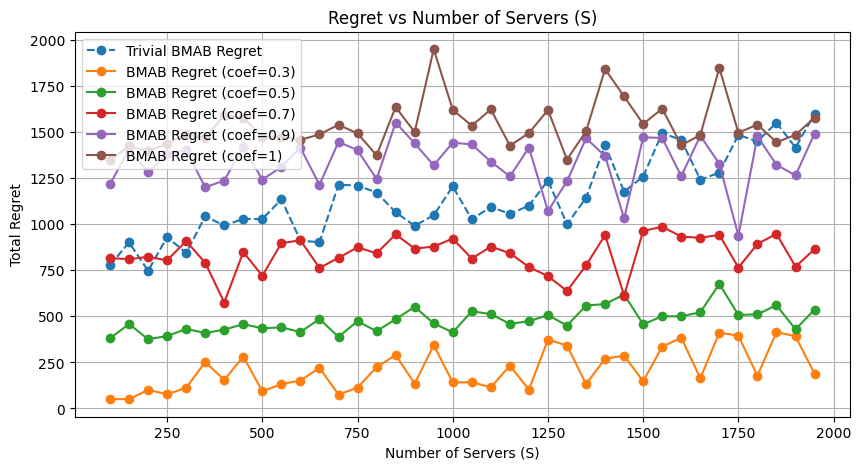

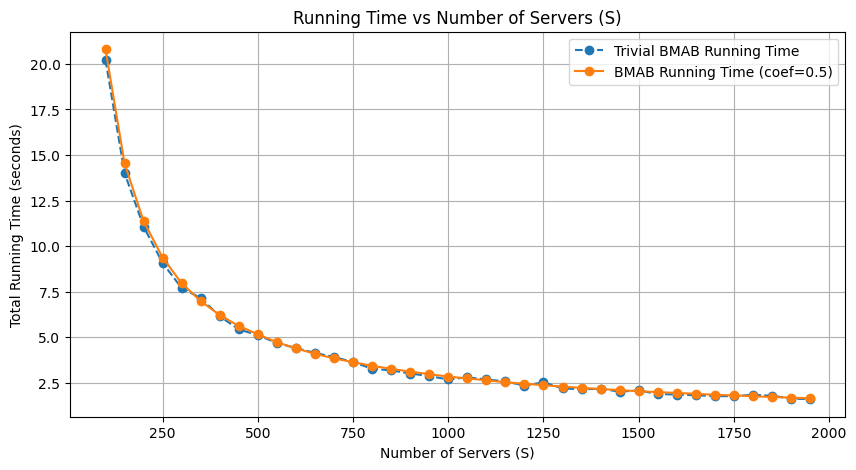

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define different batch sizes (S) to test and coefficients for BMAB
S_values = np.arange(100, 2000, 50)
coefficients = [0.3, 0.5, 0.7, 0.9, 1]

# Initialize lists to store results for each S and each coefficient
trivial_regret_values = []
trivial_running_time_values = []
regret_results = {coef: [] for coef in coefficients}  # Dict to store regrets for each coef
running_time_results = {coef: [] for coef in coefficients}  # Dict to store running times for each coef

# Run the BMAB and Trivial BMAB algorithms for each S and each coefficient, and store the results
for S in S_values:
    # Run trivial BMAB as a benchmark
    trivial_regret, trivial_total_running_time = run_trivial_offline_bmab(S)
    trivial_regret_values.append(trivial_regret)
    trivial_running_time_values.append(trivial_total_running_time)

    # Run BMAB with different coefficients
    for coef in coefficients:
        regret, total_running_time = run_offline_bmab(S, coef)
        regret_results[coef].append(regret)
        running_time_results[coef].append(total_running_time)

# Plot Regret over S for each coefficient and Trivial BMAB as a benchmark
plt.figure(figsize=(10, 5))
plt.plot(S_values, trivial_regret_values, marker='o', label='Trivial BMAB Regret', linestyle='--')

for coef in coefficients:
    plt.plot(S_values, regret_results[coef], marker='o', label=f'BMAB Regret (coef={coef})')

plt.xlabel('Number of Servers (S)')
plt.ylabel('Total Regret')
plt.title('Regret vs Number of Servers (S)')
plt.grid(True)
plt.legend()
plt.show()

# Plot Running Time over S for each coefficient and Trivial BMAB as a benchmark
plt.figure(figsize=(10, 5))
plt.plot(S_values, trivial_running_time_values, marker='o', label='Trivial BMAB Running Time', linestyle='--')

coef = 0.5
plt.plot(S_values, running_time_results[coef], marker='o', label=f'BMAB Running Time (coef={coef})')

plt.xlabel('Number of Servers (S)')
plt.ylabel('Total Running Time (seconds)')
plt.title('Running Time vs Number of Servers (S)')
plt.grid(True)
plt.legend()
plt.show()


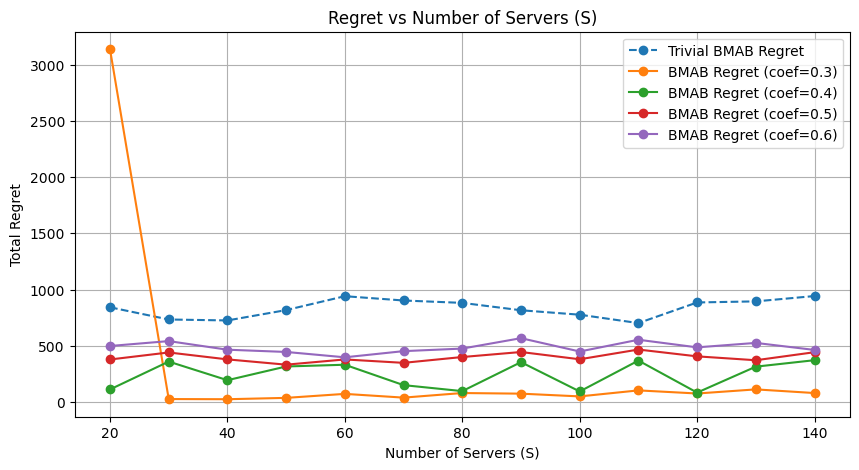

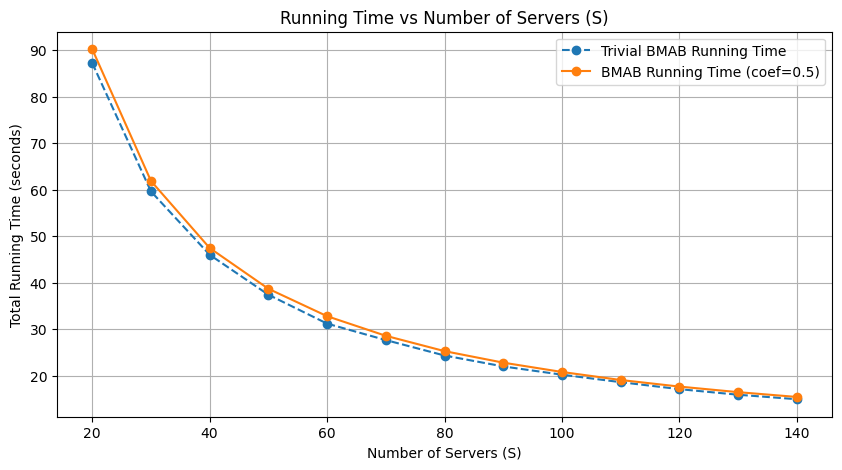

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define different batch sizes (S) to test and coefficients for BMAB
S_values = np.arange(20, 150, 10)
coefficients = [0.3, 0.4, 0.5, 0.6]

# Initialize lists to store results for each S and each coefficient
trivial_regret_values = []
trivial_running_time_values = []
regret_results = {coef: [] for coef in coefficients}  # Dict to store regrets for each coef
running_time_results = {coef: [] for coef in coefficients}  # Dict to store running times for each coef

# Run the BMAB and Trivial BMAB algorithms for each S and each coefficient, and store the results
for S in S_values:
    # Run trivial BMAB as a benchmark
    trivial_regret, trivial_total_running_time = run_trivial_offline_bmab(S)
    trivial_regret_values.append(trivial_regret)
    trivial_running_time_values.append(trivial_total_running_time)

    # Run BMAB with different coefficients
    for coef in coefficients:
        regret, total_running_time = run_offline_bmab(S, coef)
        regret_results[coef].append(regret)
        running_time_results[coef].append(total_running_time)

# Plot Regret over S for each coefficient and Trivial BMAB as a benchmark
plt.figure(figsize=(10, 5))
plt.plot(S_values, trivial_regret_values, marker='o', label='Trivial BMAB Regret', linestyle='--')

for coef in coefficients:
    plt.plot(S_values, regret_results[coef], marker='o', label=f'BMAB Regret (coef={coef})')

plt.xlabel('Number of Servers (S)')
plt.ylabel('Total Regret')
plt.title('Regret vs Number of Servers (S)')
plt.grid(True)
plt.legend()
plt.show()

# Plot Running Time over S for each coefficient and Trivial BMAB as a benchmark
plt.figure(figsize=(10, 5))
plt.plot(S_values, trivial_running_time_values, marker='o', label='Trivial BMAB Running Time', linestyle='--')

coef = 0.5
plt.plot(S_values, running_time_results[coef], marker='o', label=f'BMAB Running Time (coef={coef})')

plt.xlabel('Number of Servers (S)')
plt.ylabel('Total Running Time (seconds)')
plt.title('Running Time vs Number of Servers (S)')
plt.grid(True)
plt.legend()
plt.show()
